In [ ]:
#!/usr/bin/env python3
"""
move_val_segments.py

Move validation segments listed in val.lst from train-0 to val directory,
using os.path.join for path construction and adapting to val.lst’s “train-0/…” entries.

Folder structure example:
  data/Valentini/valentini/
      ├ train-0/
      │    ├ clean/
      │    │    └ p226/p226_001_000.wav
      │    │    └ ...
      │    └ noisy/
      │         └ p226/p226_001_000.wav
      │         └ ...
      ├ val.lst   (lines like "train-0/noisy/p226/p226_001_000.wav")
      └ (other splits)

After running, for each entry in val.lst (“train-0/clean/… ” or “train-0/noisy/…”),
the script will:
  - move the corresponding clean file from train-0/clean/... to val/clean/...
  - move the corresponding noisy file from train-0/noisy/... to val/noisy/...
"""

def train2val():
    import os
    import shutil

    # 1) Base directory where train-0 and val.lst reside
    data_root = os.path.join("data", "Valentini", "valentini")
    # Example Windows path: r"C:\Users\AITER\Documents\Pythonworkspace\SE-RL\data\Valentini\valentini"

    # 2) Paths to train-0 clean/noisy and val clean/noisy
    train0_clean_dir = os.path.join(data_root, "train-0", "clean")
    train0_noisy_dir = os.path.join(data_root, "train-0", "noisy")
    val_clean_dir = os.path.join(data_root, "val", "clean")
    val_noisy_dir = os.path.join(data_root, "val", "noisy")

    # 3) Ensure val clean/noisy directories exist
    os.makedirs(val_clean_dir, exist_ok=True)
    os.makedirs(val_noisy_dir, exist_ok=True)

    # 4) Path to val.lst
    val_list_path = os.path.join(data_root, "val.lst")
    if not os.path.exists(val_list_path):
        raise FileNotFoundError(f"val.lst not found at {val_list_path}")

    # 5) Read val.lst and move files
    with open(val_list_path, "r", encoding="utf-8") as f:
        for line in f:
            rel_path = line.strip()  # e.g., "train-0/noisy/p226/p226_001_000.wav"
            if not rel_path:
                continue

            # Split on forward slash regardless of OS
            parts = rel_path.split("/")
            # Expect parts: ["train-0", "clean" or "noisy", "p226", "p226_001_000.wav"]
            if len(parts) < 4 or parts[0] != "train-0":
                print(f"[WARN] Unexpected entry in val.lst: {rel_path}")
                continue

            _, category, spk, fname = parts[:4]
            rel_subpath = os.path.join(spk, fname)  # "p226/p226_001_000.wav"

            # Source and destination for clean
            if category == "clean":
                src_clean = os.path.join(train0_clean_dir, rel_subpath)
            else:
                src_clean = os.path.join(train0_clean_dir, spk, fname)  # still under train-0/clean
            dst_clean = os.path.join(val_clean_dir, spk, fname)
            os.makedirs(os.path.dirname(dst_clean), exist_ok=True)
            if os.path.exists(src_clean):
                shutil.move(src_clean, dst_clean)
            else:
                print(f"[WARN] Clean file not found: {src_clean}")

            # Source and destination for noisy
            if category == "noisy":
                src_noisy = os.path.join(train0_noisy_dir, rel_subpath)
            else:
                src_noisy = os.path.join(train0_noisy_dir, spk, fname)
            dst_noisy = os.path.join(val_noisy_dir, spk, fname)
            os.makedirs(os.path.dirname(dst_noisy), exist_ok=True)
            if os.path.exists(src_noisy):
                shutil.move(src_noisy, dst_noisy)
            else:
                print(f"[WARN] Noisy file not found: {src_noisy}")

    print("Finished moving all validation segments.")

In [ ]:
def testaudio():
    import soundfile as sf
    audio, sr = sf.read('data/Valentini/valentini/train-0/clean/p237/p237_001_000.wav')
    print(audio.shape, sr)

In [1]:
def count_wav_files(directory):
    import os

    count = 0
    for entry in os.scandir(directory):
        if entry.is_file() and entry.name.lower().endswith('.wav'):
            count += 1
        elif entry.is_dir():
            count += count_wav_files(entry.path)
    return count

Total .wav files: 234270


In [8]:
import torch
import torchaudio
import matplotlib.pyplot as plt
from pathlib import Path

def load_wave(path: str | Path, sr: int, mono: bool = True) -> torch.Tensor:
    """
    WAVE 파일을 로드하여 (1, T) float32 Tensor 반환.
    필요 시 sample rate를 `sr`로 리샘플링하고, stereo → mono 평균 처리.
    """
    wav, loaded_sr = torchaudio.load(str(path))
    if loaded_sr != sr:
        wav = torchaudio.functional.resample(wav, loaded_sr, sr)
    if mono and wav.shape[0] > 1:
        wav = wav.mean(dim=0, keepdim=True)
    return wav


def spec_db(wav: torch.Tensor, n_fft: int = 512, hop: int = 128) -> torch.Tensor:
    """
    STFT → 파워스펙트럼(dB).  출력 shape: (freq_bins, time_frames)
    """
    spec = torch.stft(
        wav,
        n_fft=n_fft,
        hop_length=hop,
        win_length=n_fft,
        window=torch.hann_window(n_fft),
        return_complex=True,
        center=True,
    )
    power = spec.abs().pow(2).clamp_(1e-10)
    return 10 * torch.log10(power.squeeze(0))  # (F, T)


def plot_spec_pair(
    noisy_db: torch.Tensor,
    enh_db: torch.Tensor,
    sr: int,
    hop: int,
    *,
    figsize=(12, 4),
    cmap="magma",
    save_path: str | Path | None = None,
):
    """
    로그-파워 스펙트로그램 두 장을 좌/우로 나란히 그립니다.
    """
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)
    extent = [0, noisy_db.shape[1] * hop / sr, 0, sr / 2]

    im0 = axes[0].imshow(noisy_db.flip(0), aspect="auto", cmap=cmap, extent=extent)
    axes[0].set_title("Noisy");     axes[0].set_xlabel("Time [s]"); axes[0].set_ylabel("Frequency [Hz]")
    fig.colorbar(im0, ax=axes[0])

    im1 = axes[1].imshow(enh_db.flip(0), aspect="auto", cmap=cmap, extent=extent)
    axes[1].set_title("Enhanced");  axes[1].set_xlabel("Time [s]")
    fig.colorbar(im1, ax=axes[1])

    fig.tight_layout()
    if save_path is not None:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_path, dpi=300)
        print(f"Figure saved → {save_path}")
    return fig

def show_spec_pair(
    noisy_path: str | Path,
    enh_path: str | Path,
    sr: int = 16_000,
    n_fft: int = 512,
    hop: int = 128,
    save_path: str | Path | None = None,
):
    """
    파일 경로 두 개만 주면 바로 스펙트로그램 쌍을 시각화합니다.
    """
    noisy = load_wave(noisy_path, sr)
    enh   = load_wave(enh_path,   sr)

    noisy_db = spec_db(noisy, n_fft, hop)
    enh_db   = spec_db(enh,   n_fft, hop)

    return plot_spec_pair(noisy_db, enh_db, sr, hop, save_path=save_path)

## Execute the code you want below

In [7]:
count_wav_files("data/Valentini/valentini/train-0")

234270

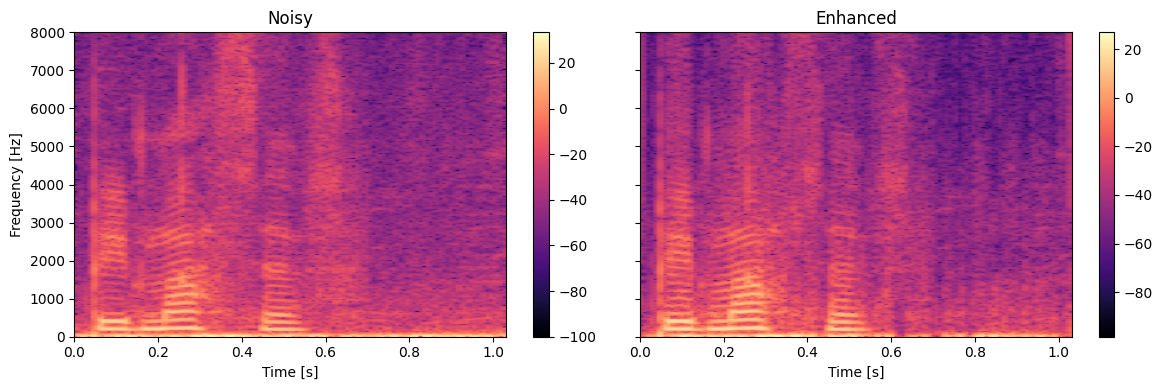

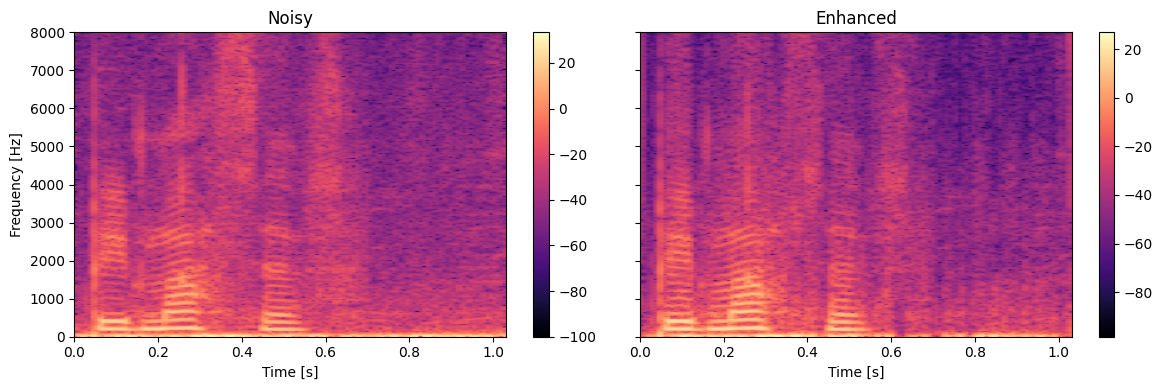

In [11]:
noisy_wav = "exp/eval_epo55/noisy_test-1/noisy/p257/p257_434_002.wav"
enh_wav   = "exp/eval_epo55/enh_test-1/noisy/p257/p257_434_002.wav"

# 화면 출력만
show_spec_pair(noisy_wav, enh_wav, sr=16000, n_fft=512, hop=128)

# 저장도 하고 싶다면
# show_spec_pair(noisy_wav, enh_wav, save_path="exp/temp/eval_out/spec_VALENTINI_123.png")
